In [6]:
# Cell 0: Import Libraries and Set Up Paths
import pandas as pd
import numpy as np
from pathlib import Path
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime, timedelta
import ta  # ta-lib for technical indicators

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Define paths
BASE_DIR = Path(r'C:\Users\yusuf\Desktop\10Academy\week_1\Predicting-Stock-Price')
DATA_DIR = BASE_DIR / 'data'
ASSETS_DIR = BASE_DIR / 'assets' / 'task3'
ASSETS_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Assets directory created/verified: {ASSETS_DIR}")

INFO: Assets directory created/verified: C:\Users\yusuf\Desktop\10Academy\week_1\Predicting-Stock-Price\assets\task3


In [16]:
# Cell 1: Load and Preprocess Data (Enhanced)

# Load news data
news_df = pd.read_csv(DATA_DIR / 'raw_analyst_ratings.csv')
logger.info(f"News data loaded: {news_df.shape}")

# Load stock data (AAPL)
stock_df = pd.read_csv(DATA_DIR / 'AAPL_historical_data.csv')
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
logger.info(f"Stock data loaded: {stock_df.shape}")

# Parse news dates robustly
news_df['Date'] = pd.to_datetime(news_df['date'], errors='coerce')
num_invalid = news_df['Date'].isna().sum()
if num_invalid > 0:
    logger.warning(f"{num_invalid} invalid news dates found.")

# Compute sentiment
news_df['Sentiment'] = news_df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
logger.info("Computed sentiment scores")

# Aggregate sentiment per day
daily_sentiment = news_df.groupby(news_df['Date'].dt.normalize())['Sentiment'].mean().reset_index()
logger.info(f"Aggregated daily sentiment shape: {daily_sentiment.shape}")

# Compute technical indicators
stock_df['RSI'] = ta.momentum.RSIIndicator(stock_df['Close'], window=14).rsi()
stock_df['MACD'] = ta.trend.MACD(stock_df['Close']).macd()
stock_df['SMA20'] = ta.trend.SMAIndicator(stock_df['Close'], window=20).sma_indicator()
stock_df['Volatility'] = stock_df['Close'].rolling(window=20).std()

# Additional engineered features
stock_df['Return'] = stock_df['Close'].pct_change()
stock_df['Lag1'] = stock_df['Return'].shift(1)  # previous day's return
stock_df['Lag2'] = stock_df['Return'].shift(2)  # 2-day lag
stock_df['Volume_Change'] = stock_df['Volume'].pct_change()

# Target variable: next day's close > today’s close
stock_df['Price_Up'] = (stock_df['Close'].shift(-1) > stock_df['Close']).astype(int)
stock_df.dropna(subset=['Price_Up'], inplace=True)
logger.info(f"Target variable created with shape: {stock_df.shape}")


INFO: News data loaded: (1407328, 6)
INFO: Stock data loaded: (10998, 9)
INFO: Computed sentiment scores
INFO: Aggregated daily sentiment shape: (2528, 2)
INFO: Target variable created with shape: (10998, 18)


In [17]:
# Cell 2: Merge Features and Prepare Dataset

# Ensure both 'Date' columns are timezone-naive (remove timezone info if any)
daily_sentiment['Date'] = daily_sentiment['Date'].dt.tz_localize(None)
stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

# Merge sentiment and stock data on Date
merged_df = stock_df.merge(daily_sentiment, on='Date', how='left')

# Replace missing sentiment values with 0 (neutral)
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)  # ✅ Fixes FutureWarning

logger.info(f"Merged dataset: {merged_df.shape}")

# Select features and target
# Updated feature set
features = ['RSI', 'MACD', 'SMA20', 'Volatility', 'Sentiment', 'Lag1', 'Lag2', 'Volume_Change']
X = merged_df[features].fillna(0)  # Handle any remaining NaNs
y = merged_df['Price_Up']

# Split into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

logger.info(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


INFO: Merged dataset: (10998, 19)
INFO: Training set: (8798, 8), Test set: (2200, 8)


In [19]:
# Cell 3: Train and Evaluate Model

# Clean infinite values
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
logger.info("Model trained")

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
logger.info(f"Accuracy: {accuracy:.2f}")
logger.info(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(ASSETS_DIR / 'confusion_matrix.png')
plt.close()
logger.info("Confusion matrix saved")

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=features)
plt.figure(figsize=(8, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.savefig(ASSETS_DIR / 'feature_importance.png')
plt.close()
logger.info("Feature importance plot saved")


INFO: Model trained
INFO: Accuracy: 0.50
INFO: Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.55      0.52      1069
           1       0.52      0.46      0.49      1131

    accuracy                           0.50      2200
   macro avg       0.50      0.50      0.50      2200
weighted avg       0.50      0.50      0.50      2200

INFO: Confusion matrix saved
INFO: Feature importance plot saved


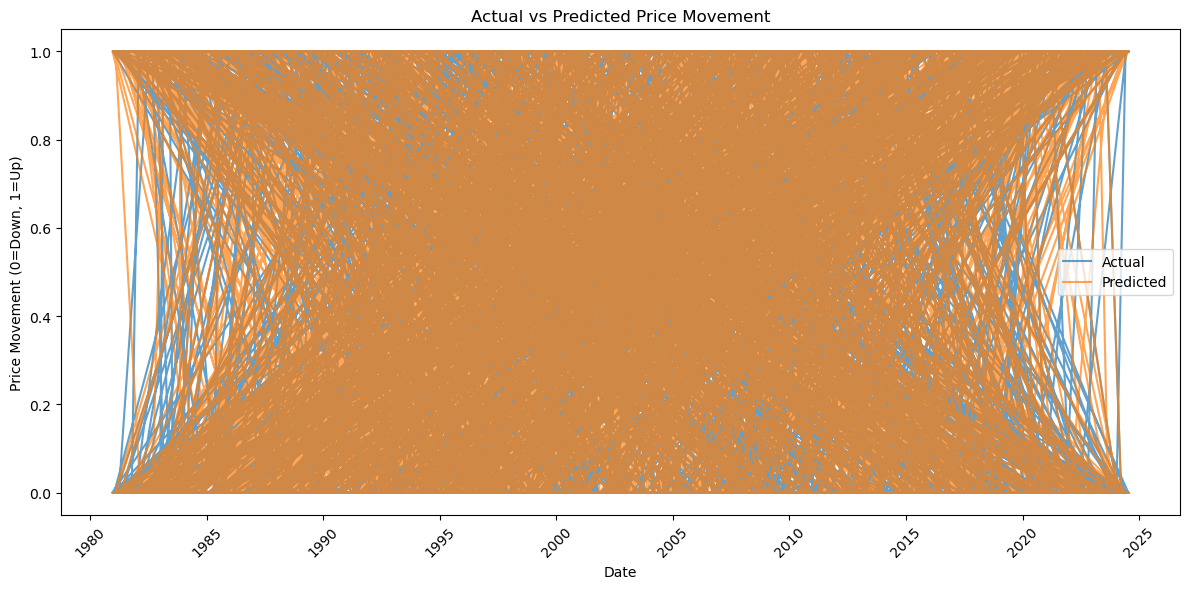

INFO: Actual vs Predicted plot saved


In [22]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted over time
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Price Movement')
plt.xlabel('Date')
plt.ylabel('Price Movement (0=Down, 1=Up)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(ASSETS_DIR / 'actual_vs_predicted.png')
plt.show()
logger.info("Actual vs Predicted plot saved")


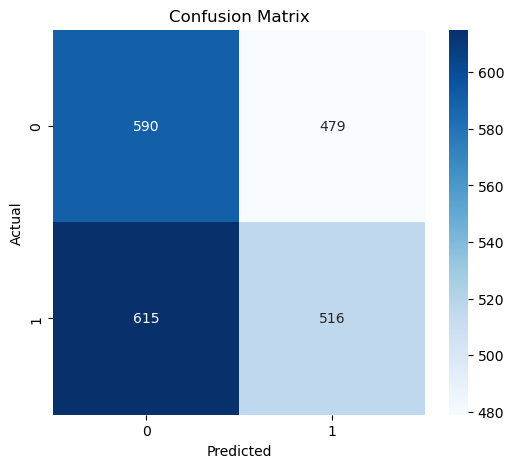

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


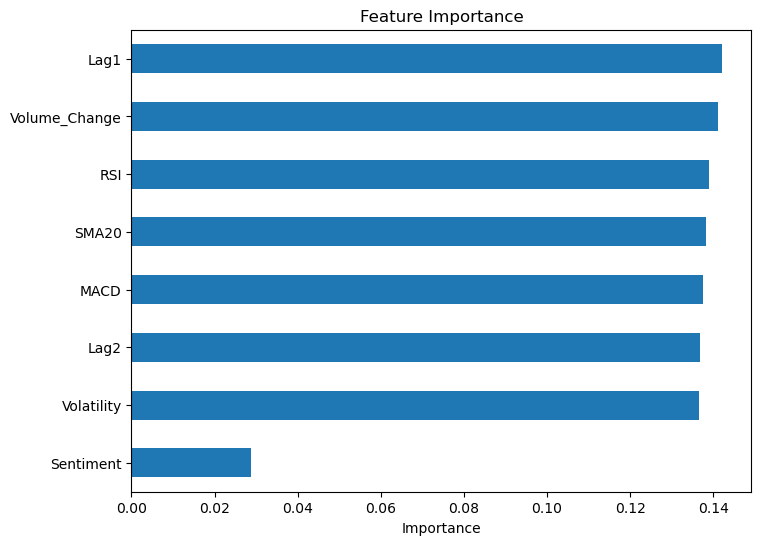

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = pd.Series(model.feature_importances_, index=features)
plt.figure(figsize=(8,6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()


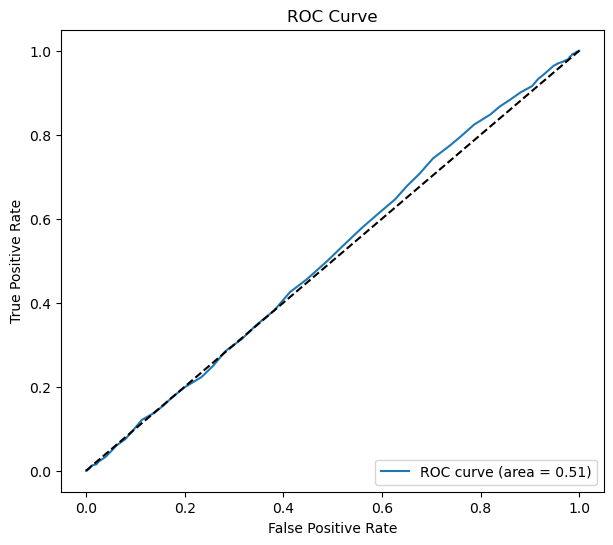

In [25]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:,1]  # probability estimates for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [26]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Ensure the models directory exists first
models_dir = BASE_DIR / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

# Save model
joblib.dump(model, models_dir / 'rf_model.pkl')
logger.info("Model saved to models/rf_model.pkl")

# Save predictions
results_df = pd.DataFrame({
    'Date': merged_df.loc[X_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})
results_df.to_csv(ASSETS_DIR / 'predictions.csv', index=False)
logger.info("Predictions saved to assets/task3/predictions.csv")

# Save confusion matrix plot
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(ASSETS_DIR / 'confusion_matrix.png')
plt.close()
logger.info("Confusion matrix image saved")

# Save feature importance plot
feature_importance = pd.Series(model.feature_importances_, index=features)
plt.figure(figsize=(8, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.savefig(ASSETS_DIR / 'feature_importance.png')
plt.close()
logger.info("Feature importance image saved")


INFO: Model saved to models/rf_model.pkl
INFO: Predictions saved to assets/task3/predictions.csv
INFO: Confusion matrix image saved
INFO: Feature importance image saved
